# Обучение модели для сегментации мозга

## Подготовка среды

In [1]:
import datetime
import os
# from typing import Optional

%matplotlib inline
import matplotlib.pyplot as plt

# import matplotlib.animation
# import models.metrics

plt.rcParams["animation.html"] = "jshtml"
import tensorflow as tf
# from IPython.display import clear_output
# import matplotlib.pyplot as plt
from loader_data import PreprocessLoadData, AnimateView
from models.model_MultiReaUNet3d import Model3DMultiResUnet
from models.model_UNet3d import Model3DUnet
import numpy as np

gpu_device = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu_device, True)



## Определяем ключевые параметры

 - **KERNEL_DIM** - Размер изображения которое подаем на вход сети. Независимо от размера исходного изображения, генератор будет делить исходное изображение на куски размером KERNEK_DIM
 - **STEP_WINDOW** - Разбиение исходного изображения на куски размером KERNEK_DIM происходит по принципу плавающего окна. STEP_WINDOW задает шаг смещения окна.
 - **BATCH_SIZE** - Количество кусков в одном батче
 - **Model** - Класс модели, которую будем обучать.

In [2]:
STEP_WINDOW = (32, 32, 32)
BATCH_SIZE = 2
KERNEL_DIM = (64, 64, 64)
Model = Model3DUnet


## Проверяем наличие данных для обучения

### Находим обучающие данные 

In [3]:

loader = PreprocessLoadData(kernel_size=KERNEL_DIM, step=STEP_WINDOW, batch_size=BATCH_SIZE)
loader.find_files()
print(f"Был найден набор из {loader.length_data()} пар данных")


Был найден набор из 369 пар данных


### Получаем генератор данных

In [4]:
train_dataset = loader.get_generator_data("train",
                                          threshold=(0.02, 0.95),
                                          random_change_plane=False,
                                          augmentation=False)
test_dataset = loader.get_generator_data("test",
                                         threshold=(0.02, 0.95),
                                         random_change_plane=False,
                                         augmentation=False)


#### Проверяем как работает генератор

(2, 64, 64, 64, 3)
(2, 64, 64, 64, 3)


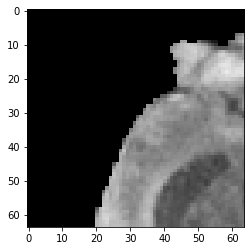

In [5]:
# %%capture
for image, mask in train_dataset:
    print(image.shape)
    print(mask.shape)
    if len(image.shape) == 4:
        ani = AnimateView().get_ani(image[:, :, :, 0])
    elif len(image.shape) == 5:
        ani = AnimateView().get_ani(image[0, :, :, :, 0])
    break
ani

## Создаем модель

 - n_channels: Размер канала входных данных.
 - initial_learning_rate: Начальная скорость обучения модели.
 - n_classes: Количество классов, которые изучает модель .
 - start_val_filters: Количество фильтров, которые будет иметь первый слой в сети.
 - list_metrics: Список метрик, для обучения модели.
 - type_up_convolution: тип повышающего слоя. up_sampling_3d использует меньше памяти.
 - pool_size: Размер пула для максимальных операций объединения. Целое число или кортеж.
 - input_img_shape: Форма входных данных кортеж(3N) или целое число (если форма соответствует кубу).
 - depth: глубина модели. Уменьшение глубины может уменьшить объем памяти, необходимый для тренировки.


In [6]:
manager_model = Model(depth=5, start_val_filters=8, input_img_shape=KERNEL_DIM, n_classes=3, n_channels=3,
                                    initial_learning_rate=0.95)


### Обучаем

In [7]:

EPOCHS = 1
STEPS_PER_EPOCH = round(1)
VALIDATION_STEPS = round(1)

checkpoint_path = 'checkpoints3D//cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_directory = os.path.join("Results", timestamp)

# Добавление отображения через TensorBoard.
log_dir = os.path.join("Results",
                       timestamp,
                       "logs",
                       "fit",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
full_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_weights_only=True,
                                       save_freq=STEPS_PER_EPOCH,
                                       verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                   histogram_freq=1,
                                   profile_batch=0,
                                   write_images=True),
    tf.keras.callbacks.EarlyStopping(monitor="loss", patience=85)]

model_history = manager_model.model.fit(train_dataset, epochs=EPOCHS,
                                        steps_per_epoch=STEPS_PER_EPOCH,
                                        validation_steps=VALIDATION_STEPS,
                                        validation_data=test_dataset,
                                        verbose=1,
                                        callbacks=full_callbacks)

manager_model.model.save(f"train.{Model.__name__}.{timestamp}")


1/1 [==============================] - ETA: 0s - loss: 0.9518 - dice_coefficient: 0.0597 - label_0_dice_coef: 0.0439 - label_1_dice_coef: 0.0808 - label_2_dice_coef: 0.0498
Epoch 00001: saving model to checkpoints3D\cp-0001.ckpt
1/1 [==============================] - 17s 17s/step - loss: 0.9518 - dice_coefficient: 0.0597 - label_0_dice_coef: 0.0439 - label_1_dice_coef: 0.0808 - label_2_dice_coef: 0.0498 - val_loss: 0.9593 - val_dice_coefficient: 0.0419 - val_label_0_dice_coef: 3.5671e-10 - val_label_1_dice_coef: 0.0636 - val_label_2_dice_coef: 0.0029
INFO:tensorflow:Assets written to: train.Model3DUnet.2021-05-09_14-33-44\assets


In [8]:
%%capture
for image, mask in test_dataset:
    pred_mask = manager_model.model.predict(image)
    # используйте порог, чтобы получить точные прогнозы
    threshold = 0.01
    pred_mask[pred_mask > threshold] = 1.0
    pred_mask[pred_mask <= threshold] = 0.0
    print(f"pred_mask.shape={pred_mask.shape}")
    if len(pred_mask.shape) == 4:
        # Область усиления контраста
        gd_enhancing_tumor_ani = AnimateView().get_ani(pred_mask[:, :, :, 2])
        # отек
        peritumoral_edema_ani = AnimateView().get_ani(pred_mask[:, :, :, 1])
        # ядро некротической и неусиливающейся опухоли
        ncr_net_ani = AnimateView().get_ani(pred_mask[:, :, :, 0])
        # T1_MRI
        t1_mri_ani = AnimateView().get_ani(image[:, :, :, 0])
        # T1_ce_MRI
        t1ce_mri_ani = AnimateView().get_ani(image[:, :, :, 1])
        # T2_MRI
        t2_mri_ani = AnimateView().get_ani(image[:, :, :, 2])
        # Оригинальная маска_0
        orign_mask_ani_0 = AnimateView().get_ani(mask[:, :, :, 0])
        # Оригинальная маска_1
        orign_mask_ani_1 = AnimateView().get_ani(mask[:, :, :, 1])
        # Оригинальная маска_2
        orign_mask_ani_2 = AnimateView().get_ani(mask[:, :, :, 2])
    elif len(pred_mask.shape) == 5:
        # Область усиления контраста
        gd_enhancing_tumor_ani = AnimateView().get_ani(pred_mask[0, :, :, :, 2])
        # peritumoral edema
        peritumoral_edema_ani = AnimateView().get_ani(pred_mask[0, :, :, :, 1])
        # NCR/NET
        ncr_net_ani = AnimateView().get_ani(pred_mask[0, :, :, :, 0])
        # T1_MRI
        t1_mri_ani = AnimateView().get_ani(image[0, :, :, :, 0])
        # T1_ce_MRI
        t1ce_mri_ani = AnimateView().get_ani(image[0, :, :, :, 1])
        # T2_MRI
        t2_mri_ani = AnimateView().get_ani(image[0, :, :, :, 2])
        # Оригинальная маска_0
        orign_mask_ani_0 = AnimateView().get_ani(mask[0, :, :, :, 0])
        # Оригинальная маска_1
        orign_mask_ani_1 = AnimateView().get_ani(mask[0, :, :, :, 1])
        # Оригинальная маска_2
        orign_mask_ani_2 = AnimateView().get_ani(mask[0, :, :, :, 2])
    break


#### T1 МРТ

In [9]:
t1_mri_ani

#### T1 Контраст МРТ

In [10]:
%%capture
t1ce_mri_ani

#### T2 МРТ

In [11]:
%%capture
t2_mri_ani

## Результат предсказания


### Область отека


In [12]:
peritumoral_edema_ani

### Область усиления контраста

In [13]:
gd_enhancing_tumor_ani

### ядро некротической и неусиливающейся опухоли

In [14]:
ncr_net_ani

### Оригинальная маска - Как должно быть

In [15]:
orign_mask_ani_1

In [16]:
orign_mask_ani_2

In [17]:
orign_mask_ani_0